In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model Creation Using Historical Sales Data from 2013 to 2023

## Loading and reviewing the data

In [39]:
# Load the data
data = pd.read_csv('Resources/clean_property_data_SQL2.csv')

# Print the columns to check for the correct column name
print(data.columns)


Index(['district', 'nbhd', 'style', 'extwall', 'stories', 'year_built',
       'rooms', 'finishedsqft', 'units', 'bdrms', 'fbath', 'hbath', 'lotsize',
       'sale_date', 'sale_price', 'sale_year', 'sale_month'],
      dtype='object')


In [40]:
# Clean column names by stripping any extra spaces
data.columns = data.columns.str.strip()
# Check the cleaned column names
print(data.columns)

Index(['district', 'nbhd', 'style', 'extwall', 'stories', 'year_built',
       'rooms', 'finishedsqft', 'units', 'bdrms', 'fbath', 'hbath', 'lotsize',
       'sale_date', 'sale_price', 'sale_year', 'sale_month'],
      dtype='object')


In [41]:
# Check data types for each column to see if any conversions are needed
data.info(type)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37759 entries, 0 to 37758
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   district      37759 non-null  int64  
 1   nbhd          37759 non-null  int64  
 2   style         37759 non-null  object 
 3   extwall       37759 non-null  object 
 4   stories       37759 non-null  float64
 5   year_built    37759 non-null  int64  
 6   rooms         37759 non-null  int64  
 7   finishedsqft  37759 non-null  int64  
 8   units         37759 non-null  int64  
 9   bdrms         37759 non-null  int64  
 10  fbath         37759 non-null  int64  
 11  hbath         37759 non-null  int64  
 12  lotsize       37759 non-null  int64  
 13  sale_date     37759 non-null  object 
 14  sale_price    37759 non-null  int64  
 15  sale_year     37759 non-null  int64  
 16  sale_month    37759 non-null  int64  
dtypes: float64(1), int64(13), object(3)
memory usage: 4.9+ MB


In [42]:
# Combining full bath and half bath columns into 1 to align with the property listings data
data['baths_total'] = data['fbath'] + data['hbath']
# Dropping 'fbath', and 'hbath' columns as they are not available in the property listings data
data = data.drop(columns=['fbath','hbath'])
# Check for any null values
data.isnull().sum()

district        0
nbhd            0
style           0
extwall         0
stories         0
year_built      0
rooms           0
finishedsqft    0
units           0
bdrms           0
lotsize         0
sale_date       0
sale_price      0
sale_year       0
sale_month      0
baths_total     0
dtype: int64

In [43]:
# Converting the sale date to datetime , becasue when imported here it couldn't read it as datetime
data['sale_date'] = pd.to_datetime(data['sale_date'], errors='coerce')
data.info(type)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37759 entries, 0 to 37758
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   district      37759 non-null  int64         
 1   nbhd          37759 non-null  int64         
 2   style         37759 non-null  object        
 3   extwall       37759 non-null  object        
 4   stories       37759 non-null  float64       
 5   year_built    37759 non-null  int64         
 6   rooms         37759 non-null  int64         
 7   finishedsqft  37759 non-null  int64         
 8   units         37759 non-null  int64         
 9   bdrms         37759 non-null  int64         
 10  lotsize       37759 non-null  int64         
 11  sale_date     37759 non-null  datetime64[ns]
 12  sale_price    37759 non-null  int64         
 13  sale_year     37759 non-null  int64         
 14  sale_month    37759 non-null  int64         
 15  baths_total   37759 non-null  int64 

In [44]:
# Dropping saledate because it's not needed for the model. We're going to use sale-year and sale-month
data = data.drop(columns=['sale_date'])
data = data.rename(columns={'sale_year': 'year', 'sale_month':'month'})
# Sorting columns by alphabetical order
data = data.reindex(sorted(data.columns), axis=1)
data

,baths_total,bdrms,district,extwall,finishedsqft,lotsize,month,nbhd,rooms,sale_price,stories,style,units,year,year_built
0,1,1,14,aluminum / vinyl,1045,1200,3,4600,0,115000,1.5,cottage,1,2013,1918
1,1,1,3,aluminum/vinyl,576,1250,6,3190,4,204000,1.0,cottage,1,2022,1890
2,1,1,14,aluminum / vinyl,512,1500,7,4910,0,67500,1.0,residence o/s,1,2013,1919
3,1,1,8,asphalt/other,792,1711,3,4120,4,60000,1.0,cottage,1,2021,1911
4,1,1,3,block,874,1736,10,2880,0,80000,1.0,cottage,1,2017,1907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37754,7,9,3,brick,7903,9900,5,3060,18,1340000,3.0,mansion,2,2022,1903
37755,8,6,3,masonry / frame,6733,11250,12,3060,0,690000,2.0,mansion,1,2017,1902
37756,8,7,3,brick,8398,58650,6,3060,15,1350000,2.0,mansion,2,2020,1912
37757,9,6,3,brick,9944,28989,6,3060,19,1825000,2.0,mansion,2,2021,1896


## Creating dummy data for the categorical column information

In [45]:
# Converting all non-numerical values to numerical category 
data_dummies = pd.get_dummies(data)
data_dummies

,baths_total,bdrms,district,finishedsqft,lotsize,month,nbhd,rooms,sale_price,stories,...,style_ranch,style_res o/s 1 story,style_res o/s 2sty +,style_res o/s a & 1/2,style_residence o/s,style_residence o/s 2sty+,style_split level,style_townhouse,style_triplex,style_tudor
0,1,1,14,1045,1200,3,4600,0,115000,1.5,...,False,False,False,False,False,False,False,False,False,False
1,1,1,3,576,1250,6,3190,4,204000,1.0,...,False,False,False,False,False,False,False,False,False,False
2,1,1,14,512,1500,7,4910,0,67500,1.0,...,False,False,False,False,True,False,False,False,False,False
3,1,1,8,792,1711,3,4120,4,60000,1.0,...,False,False,False,False,False,False,False,False,False,False
4,1,1,3,874,1736,10,2880,0,80000,1.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37754,7,9,3,7903,9900,5,3060,18,1340000,3.0,...,False,False,False,False,False,False,False,False,False,False
37755,8,6,3,6733,11250,12,3060,0,690000,2.0,...,False,False,False,False,False,False,False,False,False,False
37756,8,7,3,8398,58650,6,3060,15,1350000,2.0,...,False,False,False,False,False,False,False,False,False,False
37757,9,6,3,9944,28989,6,3060,19,1825000,2.0,...,False,False,False,False,False,False,False,False,False,False


In [46]:
# Sort the columns by alphabetical order so it's easier to organize when feeding the inputs for the model
data_dummies = data_dummies.reindex(sorted(data_dummies.columns), axis=1)

In [47]:
# Exporting the data to use for finding the missing columns from the listings data later
data_dummies.to_csv("Resources\historicalsales-dummy-data.csv")

<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Ajunjee Selvam\AppData\Local\Temp\ipykernel_21212\654857298.py:2: SyntaxWarning: invalid escape sequence '\h'
  data_dummies.to_csv("Resources\historicalsales-dummy-data.csv")


## Defining Model Features and Creating the Training and Testing Datasets

In [48]:
# Creating the independent variables set by dropping the column to be used for the target feature
X = data_dummies.drop(columns=['sale_price'])
X

,baths_total,bdrms,district,extwall_alum/vynyl siding,extwall_aluminum / vinyl,extwall_aluminum/vinyl,extwall_asphalt/other,extwall_block,extwall_brick,extwall_fiber cement/hardiplank,...,style_res o/s a & 1/2,style_residence o/s,style_residence o/s 2sty+,style_split level,style_townhouse,style_triplex,style_tudor,units,year,year_built
0,1,1,14,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,1,2013,1918
1,1,1,3,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,1,2022,1890
2,1,1,14,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,1,2013,1919
3,1,1,8,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,1,2021,1911
4,1,1,3,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,1,2017,1907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37754,7,9,3,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,2,2022,1903
37755,8,6,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,2017,1902
37756,8,7,3,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,2,2020,1912
37757,9,6,3,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,2,2021,1896


In [49]:
# Creating the dependent variable set 
y = data_dummies['sale_price']
y

0         115000
1         204000
2          67500
3          60000
4          80000
          ...   
37754    1340000
37755     690000
37756    1350000
37757    1825000
37758      60000
Name: sale_price, Length: 37759, dtype: int64

In [50]:
# Spliting data into training and testing 90/10 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Model Creation

### Linear Regression Model


In [51]:
# Setting the model to linear regression 
model = LinearRegression()
# Fitting the model 
model.fit(X_train, y_train)

LinearRegression()

In [52]:
# Evaluating the coefficients for each column to see if they have any relationship with each other
coef = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coef

,Coefficient
baths_total,25839.913084
bdrms,-4264.107482
district,-2414.606474
extwall_alum/vynyl siding,45837.644505
extwall_aluminum / vinyl,-8704.229369
extwall_aluminum/vinyl,-14907.352413
extwall_asphalt/other,-28541.040897
extwall_block,-14649.523273
extwall_brick,-9604.326566
extwall_fiber cement/hardiplank,60073.685151


In [53]:
# Ensuring X_train and y_train are in scope and convert to numeric types
X_train_numeric = sm.add_constant(X_train).astype(float)
y_train_numeric = y_train.astype(float)

# Fitting the model using statsmodels OLS
model_sm = sm.OLS(y_train_numeric, X_train_numeric).fit()

# Getting the p-values
p_values = model_sm.pvalues

# Creating a DataFrame for the coefficients and p-values
coef_pvalues = pd.DataFrame({'Coefficient': model_sm.params[1:], 'p-value': p_values[1:]})
coef_pvalues.index = X.columns
print(coef_pvalues)

# Displaying the full summary of the model
print(model_sm.summary())

                                   Coefficient        p-value
baths_total                       2.583991e+04   0.000000e+00
bdrms                            -4.264107e+03   2.043592e-25
district                         -2.414606e+03   3.494128e-86
extwall_alum/vynyl siding        -9.704551e+05  1.137786e-164
extwall_aluminum / vinyl         -1.024997e+06   0.000000e+00
extwall_aluminum/vinyl           -1.031200e+06   0.000000e+00
extwall_asphalt/other            -1.044834e+06   0.000000e+00
extwall_block                    -1.030942e+06   0.000000e+00
extwall_brick                    -1.025897e+06   0.000000e+00
extwall_fiber cement/hardiplank  -9.562191e+05   0.000000e+00
extwall_fiber-cement             -1.008483e+06   0.000000e+00
extwall_frame                    -1.025283e+06   0.000000e+00
extwall_masonary frame           -1.059234e+06   1.842564e-59
extwall_masonry / frame          -1.030301e+06   0.000000e+00
extwall_masonry/frame            -1.024581e+06   0.000000e+00
extwall_

In [54]:
# Prediction with test data 
y_pred = model.predict(X_test)
# Getting mean square 
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3657767974.0856624


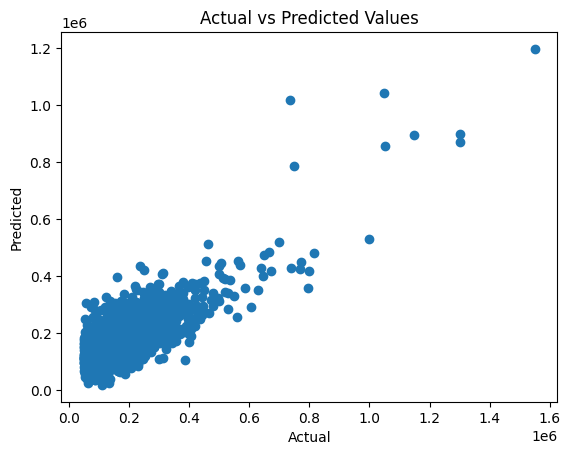

In [55]:
# Plotting graph between real and predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
# plt.ylim(0, 1600000)
plt.show()

In [56]:
# determining accuracy score 
model.score(X_test, y_test)

0.6007207053344369

### Random Forest Regression Model

In [57]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

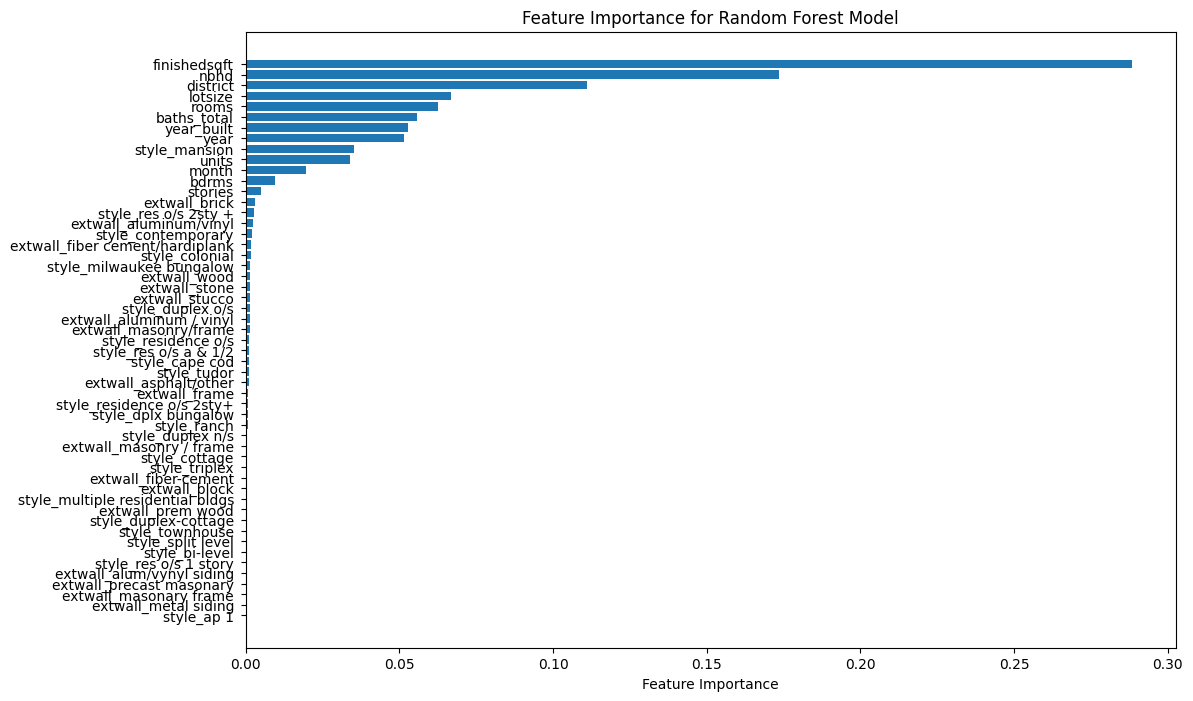

In [58]:
# Feature Importance for Random Forest
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))  # Increased figure size
plt.barh(feature_importances.index, feature_importances['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Random Forest Model')

# Adjust y-axis label spacing
plt.gca().invert_yaxis()  # Highest importance at the top
plt.gca().yaxis.set_tick_params(pad=5)  # Increase space between labels

plt.show()

In [59]:
y_pred = model.predict(X_test)
# getting mean square 
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1508305090.2988617


Text(0.5, 1.0, 'Actual vs Predicted Values')

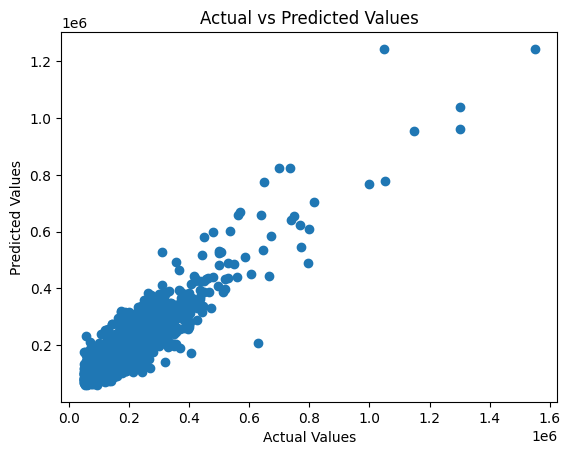

In [60]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

In [61]:
# Determining accuracy score 
model.score(X_test, y_test)

0.8353545121337147

The Random Forest Regression Model provides the best performance with an accuracy of 83.73%. Therefore, we will proceed with this model for predicting the house prices in the next section.

# House Price Prediction on 2023 Listings Data

In [62]:
# Importing the proeprty listings dataset and viewing the first 5 rows
listings_data_df = pd.read_csv("Resources/original_extracted_df_MilwaukeeOnly_June12.csv")
listings_data_df.head()

,district,nbhd,style,extwall,stories,year_built,rooms,finishedsqft,lotsize,units,...,address,zipcode,latitude,longitude,ppsq,convertedlot,lotunit,marketestimate,rentestimate,price
0,7,1680,ranch,aluminum/vinyl,1.0,1947,4,667,4356.0,1,...,North 35th STREET,53216,43.095448,-87.957344,206.146927,0.10,sqft,139700.0,996.0,137500
1,5,2080,cape cod,aluminum/vinyl,1.0,1950,4,953,4791.6,1,...,North 78th STREET,53222,43.074600,-88.009514,187.827912,0.11,sqft,192900.0,1294.0,179000
2,13,4720,colonial,aluminum/vinyl,2.0,1932,5,1152,8712.0,1,...,West Bottsford AVENUE,53221,42.964855,-87.954440,216.145833,0.20,sqft,259000.0,1994.0,249000
3,9,240,ranch,aluminum / vinyl,1.0,1992,0,1156,7840.8,1,...,West Eden PLACE,53220,42.980330,-88.002720,125.346021,0.18,sqft,157300.0,1700.0,144900
4,15,3000,colonial,aluminum/vinyl,2.0,2002,6,1184,4356.0,1,...,North 25th STREET,53205,43.056957,-87.944756,114.020270,0.10,sqft,132800.0,1500.0,135000


In [63]:
# Reviewing the datatypes to see if any conversions are needed
listings_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   district        23 non-null     int64  
 1   nbhd            23 non-null     int64  
 2   style           23 non-null     object 
 3   extwall         23 non-null     object 
 4   stories         23 non-null     float64
 5   year_built      23 non-null     int64  
 6   rooms           23 non-null     int64  
 7   finishedsqft    23 non-null     int64  
 8   lotsize         23 non-null     float64
 9   units           23 non-null     int64  
 10  bdrms           23 non-null     int64  
 11  baths_total     23 non-null     int64  
 12  state           23 non-null     object 
 13  city            23 non-null     object 
 14  address         23 non-null     object 
 15  zipcode         23 non-null     int64  
 16  latitude        23 non-null     float64
 17  longitude       23 non-null     float

In [64]:
# Dropping columns that are not needed for this project and confirming they have been dropped
listings_data_df = listings_data_df.drop(columns=['ppsq', 'convertedlot','lotunit','rentestimate'], axis=1)
listings_data_df.columns

Index(['district', 'nbhd', 'style', 'extwall', 'stories', 'year_built',
       'rooms', 'finishedsqft', 'lotsize', 'units', 'bdrms', 'baths_total',
       'state', 'city', 'address', 'zipcode', 'latitude', 'longitude',
       'marketestimate', 'price'],
      dtype='object')

In [65]:
# Creating copy of dataframe for showing results in interface
display_info_df = listings_data_df.copy()

In [66]:
# Preparing listings_data_df for input features into the model
# Setting the prediction date to June of 2024
predictions_df = listings_data_df.copy()
predictions_df = predictions_df.drop(columns=['state','city', 'address', 'zipcode', 'latitude', 'longitude', 'marketestimate','price'], axis=1)
predictions_df['year'] = 2025
predictions_df['month'] = 6
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   district      23 non-null     int64  
 1   nbhd          23 non-null     int64  
 2   style         23 non-null     object 
 3   extwall       23 non-null     object 
 4   stories       23 non-null     float64
 5   year_built    23 non-null     int64  
 6   rooms         23 non-null     int64  
 7   finishedsqft  23 non-null     int64  
 8   lotsize       23 non-null     float64
 9   units         23 non-null     int64  
 10  bdrms         23 non-null     int64  
 11  baths_total   23 non-null     int64  
 12  year          23 non-null     int64  
 13  month         23 non-null     int64  
dtypes: float64(2), int64(10), object(2)
memory usage: 2.6+ KB


In [67]:
# Converting the categorial data in 'style' and 'extwall' to dummy data columns
predictions_dummies = pd.get_dummies(predictions_df)
predictions_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   district                  23 non-null     int64  
 1   nbhd                      23 non-null     int64  
 2   stories                   23 non-null     float64
 3   year_built                23 non-null     int64  
 4   rooms                     23 non-null     int64  
 5   finishedsqft              23 non-null     int64  
 6   lotsize                   23 non-null     float64
 7   units                     23 non-null     int64  
 8   bdrms                     23 non-null     int64  
 9   baths_total               23 non-null     int64  
 10  year                      23 non-null     int64  
 11  month                     23 non-null     int64  
 12  style_bi-level            23 non-null     bool   
 13  style_cape cod            23 non-null     bool   
 14  style_coloni

In [68]:
# Exporting to compare against the historical sales dummy data to find the missing columns in the listings dummy data
predictions_dummies.to_csv("Resources\listings-dummy-data.csv")

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Ajunjee Selvam\AppData\Local\Temp\ipykernel_21212\2059668570.py:2: SyntaxWarning: invalid escape sequence '\l'
  predictions_dummies.to_csv("Resources\listings-dummy-data.csv")


In [69]:
# Fill in the missing columns from the historical sales dummy data and confirm that the current number of columns is present (52)
missing_columns = ['extwall_alum/vynyl siding','extwall_asphalt/other','extwall_block','extwall_fiber cement/hardiplank','extwall_fiber-cement','extwall_frame','extwall_masonary frame','extwall_masonry / frame','extwall_masonry/frame','extwall_metal siding','extwall_precast masonary','extwall_prem wood','extwall_stucco','style_ap 1','style_contemporary','style_cottage','style_duplex-cottage','style_mansion','style_multiple residential bldgs','style_res o/s 1 story','style_res o/s 2sty +','style_res o/s a & 1/2','style_residence o/s','style_residence o/s 2sty+','style_townhouse','style_split level','style_tudor']
for col in missing_columns:
    predictions_dummies[col] = False
predictions_dummies.head()

,district,nbhd,stories,year_built,rooms,finishedsqft,lotsize,units,bdrms,baths_total,...,style_mansion,style_multiple residential bldgs,style_res o/s 1 story,style_res o/s 2sty +,style_res o/s a & 1/2,style_residence o/s,style_residence o/s 2sty+,style_townhouse,style_split level,style_tudor
0,7,1680,1.0,1947,4,667,4356.0,1,2,1,...,False,False,False,False,False,False,False,False,False,False
1,5,2080,1.0,1950,4,953,4791.6,1,2,1,...,False,False,False,False,False,False,False,False,False,False
2,13,4720,2.0,1932,5,1152,8712.0,1,3,2,...,False,False,False,False,False,False,False,False,False,False
3,9,240,1.0,1992,0,1156,7840.8,1,3,1,...,False,False,False,False,False,False,False,False,False,False
4,15,3000,2.0,2002,6,1184,4356.0,1,3,2,...,False,False,False,False,False,False,False,False,False,False


In [70]:
# Sort the columns in alphabetical order to align with the input features order of the random forest regression model
predictions_dummies = predictions_dummies.reindex(sorted(predictions_dummies.columns), axis=1)
predictions_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   baths_total                       23 non-null     int64  
 1   bdrms                             23 non-null     int64  
 2   district                          23 non-null     int64  
 3   extwall_alum/vynyl siding         23 non-null     bool   
 4   extwall_aluminum / vinyl          23 non-null     bool   
 5   extwall_aluminum/vinyl            23 non-null     bool   
 6   extwall_asphalt/other             23 non-null     bool   
 7   extwall_block                     23 non-null     bool   
 8   extwall_brick                     23 non-null     bool   
 9   extwall_fiber cement/hardiplank   23 non-null     bool   
 10  extwall_fiber-cement              23 non-null     bool   
 11  extwall_frame                     23 non-null     bool   
 12  extwall_ma

In [71]:
# Create a copy of the predcition dummy data and run the model to get the 2024 house price predictions for the properties in the listings data
# Store the predictions in a new column in the display_info_df dataframe
X_pred1 = predictions_dummies.copy()
y_pred1 = model.predict(X_pred1)
display_info_df['predictions_2025'] = y_pred1
# Review differences to see if the house price predictions make sense
display_info_df['price_difference'] = display_info_df['predictions_2025'] - display_info_df['price'] 
display_info_df

,district,nbhd,style,extwall,stories,year_built,rooms,finishedsqft,lotsize,units,...,state,city,address,zipcode,latitude,longitude,marketestimate,price,predictions_2025,price_difference
0,7,1680,ranch,aluminum/vinyl,1.0,1947,4,667,4356.0,1,...,WI,Milwaukee,North 35th STREET,53216,43.095448,-87.957344,139700.0,137500,92647.00,-44853.00
1,5,2080,cape cod,aluminum/vinyl,1.0,1950,4,953,4791.6,1,...,WI,Milwaukee,North 78th STREET,53222,43.074600,-88.009514,192900.0,179000,207978.00,28978.00
2,13,4720,colonial,aluminum/vinyl,2.0,1932,5,1152,8712.0,1,...,WI,Milwaukee,West Bottsford AVENUE,53221,42.964855,-87.954440,259000.0,249000,249323.10,323.10
3,9,240,ranch,aluminum / vinyl,1.0,1992,0,1156,7840.8,1,...,WI,Milwaukee,West Eden PLACE,53220,42.980330,-88.002720,157300.0,144900,166512.25,21612.25
4,15,3000,colonial,aluminum/vinyl,2.0,2002,6,1184,4356.0,1,...,WI,Milwaukee,North 25th STREET,53205,43.056957,-87.944756,132800.0,135000,125888.00,-9112.00
5,10,2720,milwaukee bungalow,aluminum/vinyl,1.0,1926,7,1234,4791.6,1,...,WI,Milwaukee,S Alabama Ave,53207,42.982690,-87.887985,263300.0,249800,250578.11,778.11
6,1,900,ranch,stone,1.0,1954,5,1271,7840.8,1,...,WI,Milwaukee,North 86th PLACE,53225,43.121850,-88.019295,136300.0,135000,155658.00,20658.00
7,13,4520,colonial,aluminum/vinyl,2.0,1948,6,1300,4356.0,1,...,WI,Milwaukee,South Whitnall AVENUE,53207,42.982292,-87.905945,360000.0,339000,272259.00,-66741.00
8,7,1440,milwaukee bungalow,aluminum/vinyl,1.0,1929,7,1400,3484.8,1,...,WI,Milwaukee,South 8th STREET,53215,42.996044,-87.921000,156700.0,155000,104599.99,-50400.01
9,13,4800,ranch,aluminum / vinyl,1.0,1969,0,1500,27007.2,1,...,WI,Milwaukee,North Sherman BOULEVARD UNIT 4326,53216,43.095818,-87.966620,NaN,124900,232054.75,107154.75


In [72]:
# Export the display table for use in the final interactive dashboard if the predictions are agreeable
display_info_df.to_csv("Resources\/final-listings-dataset-with-predictions.csv")

<>:2: SyntaxWarning: invalid escape sequence '\/'
<>:2: SyntaxWarning: invalid escape sequence '\/'
C:\Users\Ajunjee Selvam\AppData\Local\Temp\ipykernel_21212\809766883.py:2: SyntaxWarning: invalid escape sequence '\/'
  display_info_df.to_csv("Resources\/final-listings-dataset-with-predictions.csv")


In [73]:
# Make a copy of the display data for further manipulation
revised_display_info_df = display_info_df.copy()
# If the differences are negative, multiple by -2 and add it to the house price prediction to ensure the predicted price is higher than the 2023 listing price
revised_display_info_df.loc[revised_display_info_df['price_difference'] <= 0, 'predictions_2025'] = revised_display_info_df['predictions_2025'] + revised_display_info_df['price_difference'] * (-2)
revised_display_info_df['price_difference'] = revised_display_info_df['predictions_2025'] - revised_display_info_df['price'] 
revised_display_info_df

,district,nbhd,style,extwall,stories,year_built,rooms,finishedsqft,lotsize,units,...,state,city,address,zipcode,latitude,longitude,marketestimate,price,predictions_2025,price_difference
0,7,1680,ranch,aluminum/vinyl,1.0,1947,4,667,4356.0,1,...,WI,Milwaukee,North 35th STREET,53216,43.095448,-87.957344,139700.0,137500,182353.00,44853.00
1,5,2080,cape cod,aluminum/vinyl,1.0,1950,4,953,4791.6,1,...,WI,Milwaukee,North 78th STREET,53222,43.074600,-88.009514,192900.0,179000,207978.00,28978.00
2,13,4720,colonial,aluminum/vinyl,2.0,1932,5,1152,8712.0,1,...,WI,Milwaukee,West Bottsford AVENUE,53221,42.964855,-87.954440,259000.0,249000,249323.10,323.10
3,9,240,ranch,aluminum / vinyl,1.0,1992,0,1156,7840.8,1,...,WI,Milwaukee,West Eden PLACE,53220,42.980330,-88.002720,157300.0,144900,166512.25,21612.25
4,15,3000,colonial,aluminum/vinyl,2.0,2002,6,1184,4356.0,1,...,WI,Milwaukee,North 25th STREET,53205,43.056957,-87.944756,132800.0,135000,144112.00,9112.00
5,10,2720,milwaukee bungalow,aluminum/vinyl,1.0,1926,7,1234,4791.6,1,...,WI,Milwaukee,S Alabama Ave,53207,42.982690,-87.887985,263300.0,249800,250578.11,778.11
6,1,900,ranch,stone,1.0,1954,5,1271,7840.8,1,...,WI,Milwaukee,North 86th PLACE,53225,43.121850,-88.019295,136300.0,135000,155658.00,20658.00
7,13,4520,colonial,aluminum/vinyl,2.0,1948,6,1300,4356.0,1,...,WI,Milwaukee,South Whitnall AVENUE,53207,42.982292,-87.905945,360000.0,339000,405741.00,66741.00
8,7,1440,milwaukee bungalow,aluminum/vinyl,1.0,1929,7,1400,3484.8,1,...,WI,Milwaukee,South 8th STREET,53215,42.996044,-87.921000,156700.0,155000,205400.01,50400.01
9,13,4800,ranch,aluminum / vinyl,1.0,1969,0,1500,27007.2,1,...,WI,Milwaukee,North Sherman BOULEVARD UNIT 4326,53216,43.095818,-87.966620,NaN,124900,232054.75,107154.75


In [74]:
# Export the final display table for use in the final interactive dashboard
revised_display_info_df.to_csv("Resources\\revised-final-listings-dataset-with-predictions.csv")